In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !unzip /content/gdrive/MyDrive/Data/dataset.zip > /dev/null

In [ ]:
# Import Libraries

import matplotlib.pylab as plt
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Read image paths

imagePaths=[]
for root, dirnames, filenames in os.walk(r'../dataset'):
    for filename in filenames:
        if (filename[-3:] == 'jpg'):
            imagePaths.append(os.path.join(root, filename))
            
print(len(imagePaths))

25260


In [ ]:
image=plt.imread(imagePaths[0])
image.shape

(128, 64, 3)

In [ ]:
# AutoEncoder

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Reshape, BatchNormalization

input_shape=(64, 64, 3)
encoding_dim = 32

# Encoder
encoder = Sequential([
    Conv2D(input_shape=input_shape, filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='LeakyReLU', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(16, (3, 3), activation='LeakyReLU', padding='same'),
    Flatten(),
    Dense(256, activation='LeakyReLU'),
    BatchNormalization(),
    Dense(128, activation='LeakyReLU'),
    BatchNormalization(),
    Dense(encoding_dim, activation='LeakyReLU')
])

# Decoder
decoder = Sequential([
    Dense(128, activation='LeakyReLU', input_shape=(encoding_dim,)),
    BatchNormalization(),
    Dense(8*8*3, activation='LeakyReLU'),
    BatchNormalization(),
    Reshape((8, 8, 3)),
    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), activation='LeakyReLU', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='LeakyReLU', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])


autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
autoencoder_dr.compile(loss = 'mse')

In [ ]:
autoencoder_dr.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68_input (InputLayer  [(None, 64, 64, 3)]      0         
 )                                                               
                                                                 
 conv2d_68 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                          

In [ ]:
decoder.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 128)               4224      
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_80 (Dense)            (None, 192)               24768     
                                                                 
 batch_normalization_7 (Batc  (None, 192)              768       
 hNormalization)                                                 
                                                                 
 reshape_12 (Reshape)        (None, 8, 8, 3)           0         
                                                                 
 up_sampling2d_27 (UpSamplin  (None, 16, 16, 3)      

In [ ]:
# Compile the model

autoencoder_dr = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
autoencoder_dr.compile(loss = 'mse')

In [ ]:
#Early Sopping

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [ ]:
from sklearn.model_selection import train_test_split

# Test Train Split

imagePathsTrain, imagePathsTest = train_test_split(imagePaths, test_size=0.1, random_state=42)
print(len(imagePathsTrain), len(imagePathsTest))

22734 2526


In [ ]:
x_train = []
x_val = []
train = []

for i in range(len(imagePathsTrain)):
  if i%7000 == 0 and i!=0:
    # Train the autoencoder
    x_train, x_val = train_test_split(train, test_size=0.2, random_state=42)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    print(np.array(train).shape, x_train.shape, x_val.shape, i)
    autoencoder_dr.fit(x_train, x_train, epochs=100, batch_size=64, shuffle=True, validation_data=(x_val, x_val), callbacks=[es])
    train = []
    x_train = []
    x_val = []
  try:
    # Process the images
    image=plt.imread(imagePaths[i])
    image=cv2.resize(image, (64, 64))
    image = image/255
    train.append(image)
  except:
    pass
x_train, x_val = train_test_split(train, test_size=0.2, random_state=42)
x_train = np.array(x_train)
x_val = np.array(x_val)
print(np.array(train).shape, x_train.shape, x_val.shape)
autoencoder_dr.fit(x_train, x_train, epochs=100, batch_size=32, shuffle=True, validation_data=(x_val, x_val))

(7000, 64, 64, 3) (5600, 64, 64, 3) (1400, 64, 64, 3) 7000
Epoch 1/100
88/88 [==============================] - 8s 35ms/step - loss: 0.0284 - val_loss: 0.0412
Epoch 2/100
88/88 [==============================] - 2s 26ms/step - loss: 0.0233 - val_loss: 0.0347
Epoch 3/100
88/88 [==============================] - 2s 26ms/step - loss: 0.0220 - val_loss: 0.0280
Epoch 4/100
88/88 [==============================] - 3s 29ms/step - loss: 0.0211 - val_loss: 0.0253
Epoch 5/100
88/88 [==============================] - 2s 27ms/step - loss: 0.0205 - val_loss: 0.0226
Epoch 6/100
88/88 [==============================] - 2s 26ms/step - loss: 0.0201 - val_loss: 0.0223
Epoch 7/100
88/88 [==============================] - 2s 27ms/step - loss: 0.0197 - val_loss: 0.0206
Epoch 8/100
88/88 [==============================] - 2s 26ms/step - loss: 0.0195 - val_loss: 0.0210
Epoch 9/100
88/88 [==============================] - 2s 28ms/step - loss: 0.0192 - val_loss: 0.0204
Epoch 10/100
88/88 [=====================

In [ ]:
# Save model
autoencoder_dr.save("autoencoder_v2.h5")

In [ ]:
encoder.save("encoder_v2.h5")
decoder.save("decoder_v2.h5")

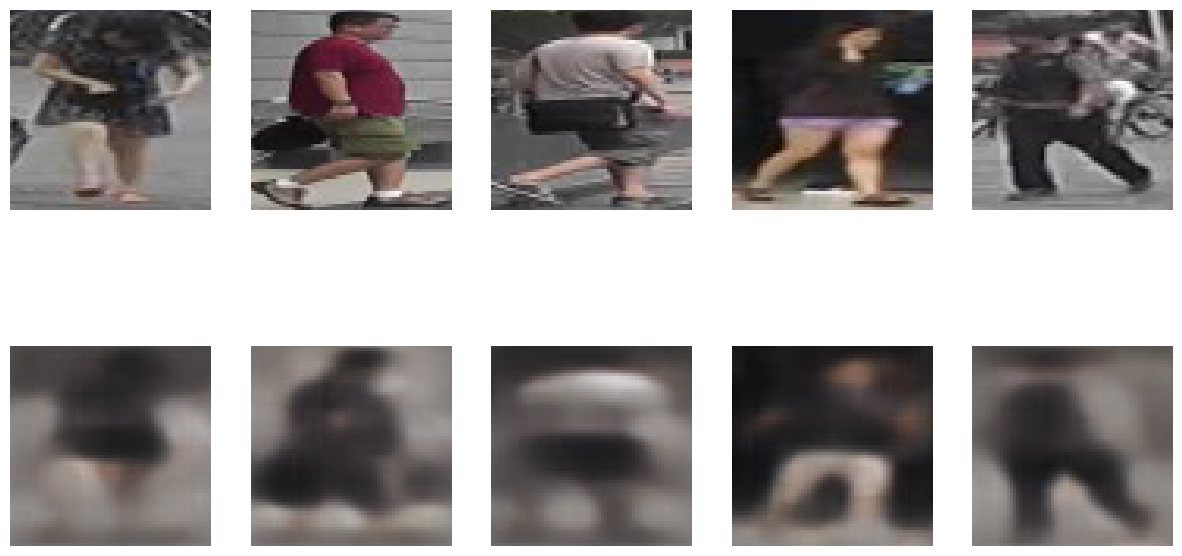

In [ ]:
# Test images

x_test=[]
for i in range(len(imagePathsTest)):
  image=plt.imread(imagePaths[i])
  image=cv2.resize(image, (64, 64))
  image = image/255
  x_test.append(image)
x_test=np.array(x_test)

reconstructed_img = autoencoder_dr(x_test[0:5])

f, axs = plt.subplots(2, 5, figsize=(15, 8))
for j in range(5):
    axs[0, j].imshow(x_test[j], cmap='binary')
    axs[1, j].imshow(reconstructed_img[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')

In [ ]:
# Write features to files

fp = open("autoencoder_features_v2.txt", "w")
for i in imagePaths:
  try:
    image=plt.imread(i)
    image = image/255
    image=cv2.resize(image, (64, 64))
    fp.write(i+","+",".join(map(str, encoder(np.array([image])).numpy()[0].tolist()))+"\n")
  except:
    pass
fp.close()

In [ ]:
# !wc -l /content/gdrive/MyDrive/data/autoencoder_features_v2.txt

0 /content/gdrive/MyDrive/data/autoencoder_features_v2.txt


In [ ]:
# Read feature files

image_path = []
image_features = []
fp = open("autoencoder_features_v2.txt", "r")
for line in fp:
  line = line.strip()
  image_path.append(line.split(",")[0].split("/")[1].split(",")[0])
  image_features.append(list(map(float, line.split(",")[1:])))

In [ ]:
image_features = np.array(image_features)
image_features.shape

(25259, 32)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[1165716.0718701845, 1084388.5303977097, 1011073.3691689268, 969480.4264553259, 939561.1887474624, 917431.6083863784, 900175.9663523491, 885770.9023167053, 873448.1836454327, 863105.9146149334, 852779.3067773639, 830152.0108355262, 810929.0756366448, 791902.1723919935, 771317.8110629492, 755135.8177185305, 740090.1610357233, 728858.2464135285, 717458.3222583836]


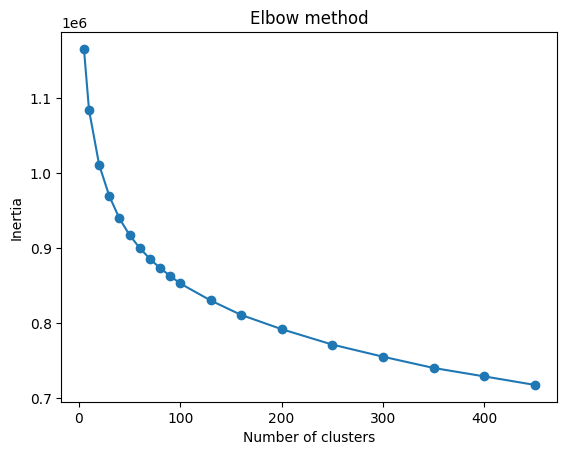

In [ ]:
# Cluster Extracted Features KMEans

from sklearn.cluster import KMeans

inertias = []
cluster_list = [5,10,20,30,40,50,60,70,80,90,100,130,160,200,250,300,350,400,450]
for i in cluster_list:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(image_features)
    inertias.append(kmeans.inertia_)

print(inertias)

plt.plot(cluster_list, inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
# Cluster Extracted Features DBSCAN

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=12, min_samples=2, algorithm = 'kd_tree')
dbscan.fit(image_features)

DBSCAN(algorithm='kd_tree', eps=12, min_samples=2)

In [ ]:
labels = dbscan.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

In [ ]:
n_clusters

760

In [ ]:
image_features.shape

(25259, 32)